In [1]:
import datetime as datetime  
import numpy as np
import seaborn as sns
import pandas as pd  
import statsmodels.api as sm  
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import matplotlib.pyplot as plt
import os
% matplotlib inline
sns.set_context('poster')

/cvmfs/sft.cern.ch/lcg/releases/matplotlib/1.5.1-b2015/x86_64-slc6-gcc62-opt/lib/python3.5/site-packages/matplotlib-1.5.1-py3.5-linux-x86_64.egg/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/cvmfs/sft.cern.ch/lcg/releases/matplotlib/1.5.1-b2015/x86_64-slc6-gcc62-opt/lib/python3.5/site-packages/matplotlib-1.5.1-py3.5-linux-x86_64.egg/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
data = pd.read_csv('../atlas_rucio-events-2017.06.21.csv')
print(data.info())
data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2085203 entries, 0 to 2085202
Data columns (total 27 columns):
Unnamed: 0             int64
account                float64
activity               object
bytes                  int64
checksum-adler         object
checksum-md5           float64
dst-rse                object
dst-type               object
dst-url                object
duration               int64
guid                   float64
name                   object
previous-request-id    object
protocol               object
reason                 float64
request-id             object
scope                  object
src-rse                object
src-type               object
src-url                object
started_at             object
submitted_at           object
tool-id                object
transfer-endpoint      object
transfer-id            object
transfer-link          object
transferred_at         object
dtypes: float64(4), int64(3), object(20)
memory usage: 429.5+ MB
None


(2085203, 27)

In [29]:
def load_encoders():
    src_encoder = LabelEncoder()
    dst_encoder = LabelEncoder()
    type_encoder = LabelEncoder()
    activity_encoder = LabelEncoder()
    protocol_encoder = LabelEncoder()
    t_endpoint_encoder = LabelEncoder()
    
    src_encoder.classes_ = np.load('encoders/ddm_rse_endpoints.npy')
    dst_encoder.classes_ = np.load('encoders/ddm_rse_endpoints.npy')
    type_encoder.classes_ = np.load('encoders/type.npy')
    activity_encoder.classes_ = np.load('encoders/activity.npy')
    protocol_encoder.classes_ = np.load('encoders/protocol.npy')
    t_endpoint_encoder.classes_ = np.load('encoders/endpoint.npy')
    
    return (src_encoder,dst_encoder,type_encoder,activity_encoder,protocol_encoder,t_endpoint_encoder)

def train_encoders(rucio_data, use_cache=True):
    
    if use_cache:
        if os.path.isfile('encoders/ddm_rse_endpoints.npy') and os.path.isfile('encoders/activity.npy'):
            print('using cached LabelEncoders for encoding data.....')
            src_encoder,dst_encoder,type_encoder,activity_encoder,protocol_encoder,t_endpoint_encoder=load_encoders()
        else:
            print('NO cache found')
    else:
        print('No cached encoders found ! Training Some New Ones using input data!')
        src_encoder = LabelEncoder()
        dst_encoder = LabelEncoder()
        type_encoder = LabelEncoder()
        activity_encoder = LabelEncoder()
        protocol_encoder = LabelEncoder()
        t_endpoint_encoder = LabelEncoder()

        src_encoder.fit(rucio_data['src-rse'].unique())
        dst_encoder.fit(rucio_data['dst-rse'].unique())
        type_encoder.fit(rucio_data['src-type'].unique())
        activity_encoder.fit(rucio_data['activity'].unique())
        protocol_encoder.fit(rucio_data['protocol'].unique())
        t_endpoint_encoder.fit(rucio_data['transfer-endpoint'].unique())

        np.save('encoders/src.npy', src_encoder.classes_)
        np.save('encoders/dst.npy', dst_encoder.classes_)
        np.save('encoders/type.npy', type_encoder.classes_)
        np.save('encoders/activity.npy', activity_encoder.classes_)
        np.save('encoders/protocol.npy', protocol_encoder.classes_)
        np.save('encoders/endpoint.npy', t_endpoint_encoder.classes_)
    
    return (src_encoder,dst_encoder,type_encoder,activity_encoder,protocol_encoder,t_endpoint_encoder)

def preprocess_data(rucio_data, use_cache=True):
    
    fields_to_drop = ['account','reason','checksum-adler','checksum-md5','guid','request-id','transfer-id','tool-id',
                      'transfer-link','name','previous-request-id','scope','src-url','dst-url', 'Unnamed: 0']
    timestamps = ['started_at', 'submitted_at','transferred_at']

    #DROP FIELDS , CHANGE TIME FORMAT, add dataetime index
    rucio_data = rucio_data.drop(fields_to_drop, axis=1)
    for timestamp in timestamps:
        rucio_data[timestamp]= pd.to_datetime(rucio_data[timestamp], infer_datetime_format=True)
    rucio_data['delay'] = rucio_data['started_at'] - rucio_data['submitted_at']
    rucio_data['delay'] = rucio_data['delay'].astype('timedelta64[s]')
    
    rucio_data = rucio_data.sort_values(by='submitted_at')
    rucio_data.index = pd.DatetimeIndex(rucio_data['submitted_at'])

    rucio_data = rucio_data.drop(timestamps, axis=1)
    
    # Normalization
    
    byte_scaler = MinMaxScaler(feature_range=(0, 1))
    delay_scaler = MinMaxScaler(feature_range=(0, 1))
    duration_scaler = MinMaxScaler(feature_range=(0, 1))
    
    byte_scaler = byte_scaler.fit(rucio_data['bytes'])
    delay_scaler = delay_scaler.fit(rucio_data['delay'])
    duration_scaler = duration_scaler.fit(rucio_data['duration'])
    
    rucio_data['bytes'] = byte_scaler.transform(rucio_data['bytes'])
    rucio_data['delay'] = delay_scaler.transform(rucio_data['delay'])
    rucio_data['duration'] = duration_scaler.transform(rucio_data['duration'])
    
    # encode categorical data
 
    if use_cache==True:
        src_encoder,dst_encoder,type_encoder,activity_encoder,protocol_encoder,t_endpoint_encoder = train_encoders(rucio_data, use_cache=True)
    else:
        src_encoder,dst_encoder,type_encoder,activity_encoder,protocol_encoder,t_endpoint_encoder = train_encoders(rucio_data, use_cache=False)

    rucio_data['src-rse'] = src_encoder.transform(rucio_data['src-rse'])
    rucio_data['dst-rse'] = dst_encoder.transform(rucio_data['dst-rse'])
    rucio_data['src-type'] = type_encoder.transform(rucio_data['src-type'])
    rucio_data['dst-type'] = type_encoder.transform(rucio_data['dst-type'])
    rucio_data['activity'] = activity_encoder.transform(rucio_data['activity'])
    rucio_data['protocol'] = protocol_encoder.transform(rucio_data['protocol'])
    rucio_data['transfer-endpoint'] = t_endpoint_encoder.transform(rucio_data['transfer-endpoint'])
    
    return rucio_data, byte_scaler, delay_scaler, duration_scaler

def split_data(rucio_data,durations, num_timesteps=50, split_frac=0.9):
    
#     slice_size = batch_size*num_timesteps
    print(rucio_data.shape[0])
    n_examples = rucio_data.shape[0]
    n_batches = (n_examples - num_timesteps )
    print('Total Batches : {}'.format(n_batches))
    
    inputs=[]
    outputs=[]
    for i in range(0,n_batches):
        v = rucio_data[i:i+num_timesteps]
        w = durations[i+num_timesteps]
        inputs.append(v)
        outputs.append(w)
    
    inputs = np.stack(inputs)
    outputs = np.stack(outputs)
    print(inputs.shape, outputs.shape)
    
    split_idx = int(inputs.shape[0]*split_frac)
    trainX, trainY = inputs[:split_idx], outputs[:split_idx]
    testX, testY = inputs[split_idx:], outputs[split_idx:]
    print('Training Data shape:',trainX.shape, trainY.shape)
    print('Test Data shape: ',testX.shape, testY.shape)
    return trainX, trainY, testX, testY

def plot_graphs(data):
    
    durations = data['duration']
    durations.plot()
    plt.ylabel('durations')
    plt.show()

    filesize = data['bytes']
    filesize.plot(label='filesize')
    plt.ylabel('bytes')
    plt.show()

    delays = data['delay']
    delays.plot(label='delay')
    plt.ylabel('delay')
    plt.show()

    plt.plot(filesize, 'r', label='filesize')
    plt.plot(durations, 'y', label='durations')
    plt.plot(delays,'g', label='queue-time')
    plt.legend()
    plt.show()

In [4]:
# data = data[:10000]

In [5]:
data, byte_scaler, delay_scaler, duration_scaler  = preprocess_data(data)

/cvmfs/sft.cern.ch/lcg/views/LCG_88Py3/x86_64-slc6-gcc62-opt/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/cvmfs/sft.cern.ch/lcg/views/LCG_88Py3/x86_64-slc6-gcc62-opt/lib/python3.5/site-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/cvmfs/sft.cern.ch/lcg/views/LCG_88Py3/x86_64-slc6-gcc62-opt/lib/python3.5/site-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1,

using cached LabelEncoders for encoding data.....


In [6]:
data.head(20)

,activity,bytes,dst-rse,dst-type,duration,protocol,src-rse,src-type,transfer-endpoint,delay
submitted_at,,,,,,,,,,
2017-06-14 00:59:55,1,2.185302e-02,482,0,0.005138,2,310,0,0,0.994136
2017-06-14 03:35:27,1,7.828251e-02,526,0,0.008849,2,310,0,0,0.998567
2017-06-14 04:25:07,1,6.519615e-03,526,0,0.000999,2,310,0,0,0.996835
2017-06-14 06:17:14,1,5.891379e-02,526,0,0.009919,2,310,0,0,0.997889
2017-06-14 08:36:38,11,1.470533e-08,533,0,0.000428,2,325,0,0,0.983981
2017-06-14 08:53:43,11,1.687399e-06,533,0,0.000428,2,325,0,0,0.955915
2017-06-14 09:04:40,11,1.414678e-04,533,0,0.000428,2,325,0,0,1.000000
2017-06-14 09:04:41,11,2.722057e-02,533,0,0.003497,2,325,0,0,0.999998
2017-06-14 09:04:41,11,2.715398e-02,533,0,0.003996,2,325,0,0,0.999998


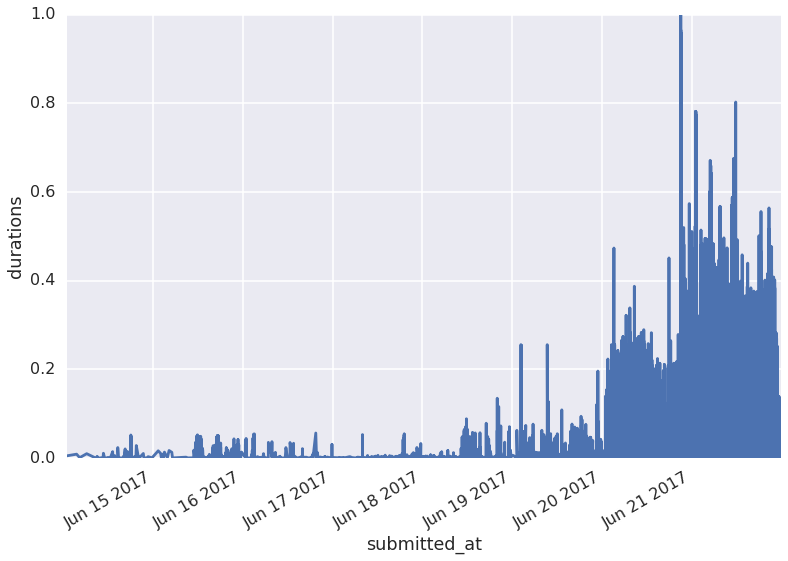

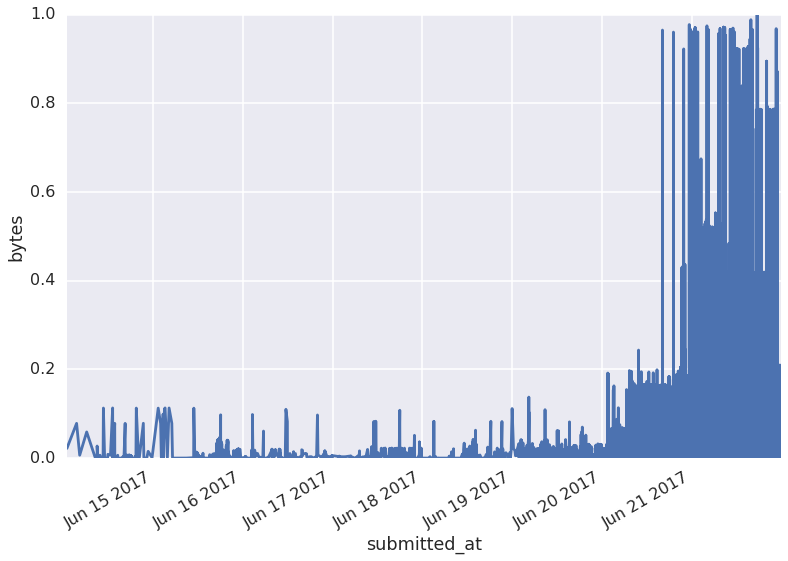

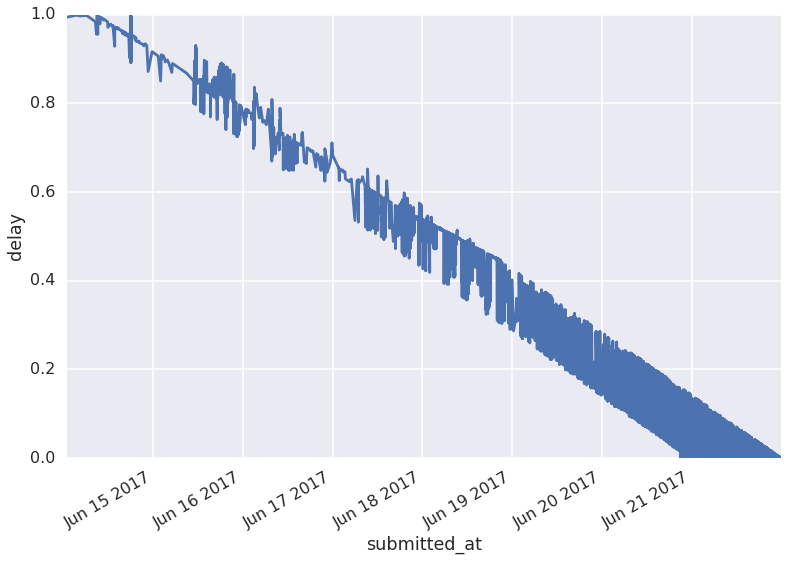

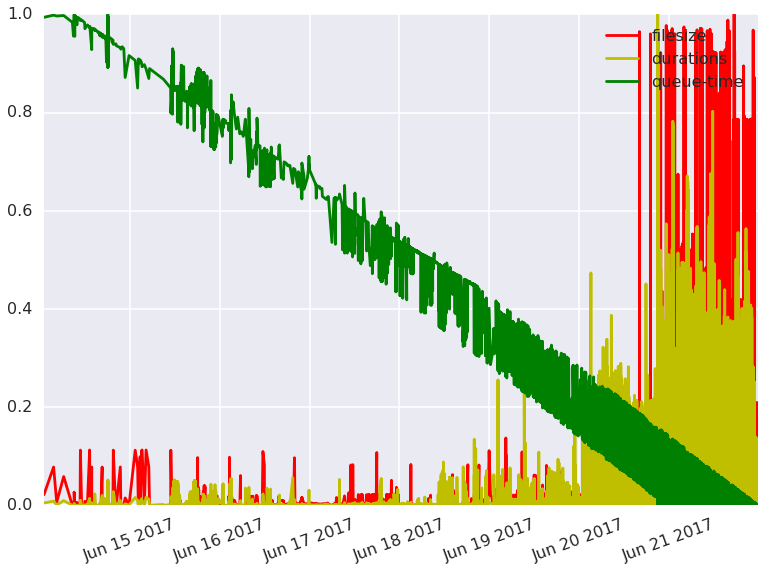

In [32]:
def plot_graphs(data):
    
    durations = data['duration']
    durations.plot()
    plt.ylabel('durations')
    plt.show()

    filesize = data['bytes']
    filesize.plot(label='filesize')
    plt.ylabel('bytes')
    plt.show()

    delays = data['delay']
    delays.plot(label='delay')
    plt.ylabel('delay')
    plt.show()

    plt.plot(filesize, 'r', label='filesize')
    plt.plot(durations, 'y', label='durations')
    plt.plot(delays,'g', label='queue-time')
    plt.legend()
    plt.xticks(rotation=20)
    plt.show()
    
plot_graphs(data)

In [51]:
path = '../' # Change this as you need.

def plot_rucio(path='../'):
    abspaths = []
    for fn in os.listdir(path):
        if 'atlas_rucio' in fn:
            abspaths.append(os.path.abspath(os.path.join(path, fn)))
    print("\n".join(abspaths))
    
    for path in abspaths:
        print('reading : ',path)
        data = pd.read_csv(path)
        print('shape :', data.shape)
        data, byte_scaler, delay_scaler, duration_scaler  = preprocess_data(data)
        plot_graphs(data)


/eos/user/v/vysharma/atlas_rucio-events-2017.06.01.csv
/eos/user/v/vysharma/atlas_rucio-events-2017.06.02.csv
/eos/user/v/vysharma/atlas_rucio-events-2017.06.03.csv
/eos/user/v/vysharma/atlas_rucio-events-2017.06.04.csv
/eos/user/v/vysharma/atlas_rucio-events-2017.06.05.csv
/eos/user/v/vysharma/atlas_rucio-events-2017.06.06.csv
/eos/user/v/vysharma/atlas_rucio-events-2017.06.07.csv
/eos/user/v/vysharma/atlas_rucio-events-2017.06.08.csv
/eos/user/v/vysharma/atlas_rucio-events-2017.06.09.csv
/eos/user/v/vysharma/atlas_rucio-events-2017.06.10.csv
/eos/user/v/vysharma/atlas_rucio-events-2017.06.11.csv
/eos/user/v/vysharma/atlas_rucio-events-2017.06.12.csv
/eos/user/v/vysharma/atlas_rucio-events-2017.06.13.csv
/eos/user/v/vysharma/atlas_rucio-events-2017.06.14.csv
/eos/user/v/vysharma/atlas_rucio-events-2017.06.15.csv
/eos/user/v/vysharma/atlas_rucio-events-2017.06.16.csv
/eos/user/v/vysharma/atlas_rucio-events-2017.06.17.csv
/eos/user/v/vysharma/atlas_rucio-events-2017.06.18.csv
/eos/user/

/cvmfs/sft.cern.ch/lcg/views/LCG_88Py3/x86_64-slc6-gcc62-opt/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/cvmfs/sft.cern.ch/lcg/views/LCG_88Py3/x86_64-slc6-gcc62-opt/lib/python3.5/site-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/cvmfs/sft.cern.ch/lcg/views/LCG_88Py3/x86_64-slc6-gcc62-opt/lib/python3.5/site-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1,

using cached LabelEncoders for encoding data.....


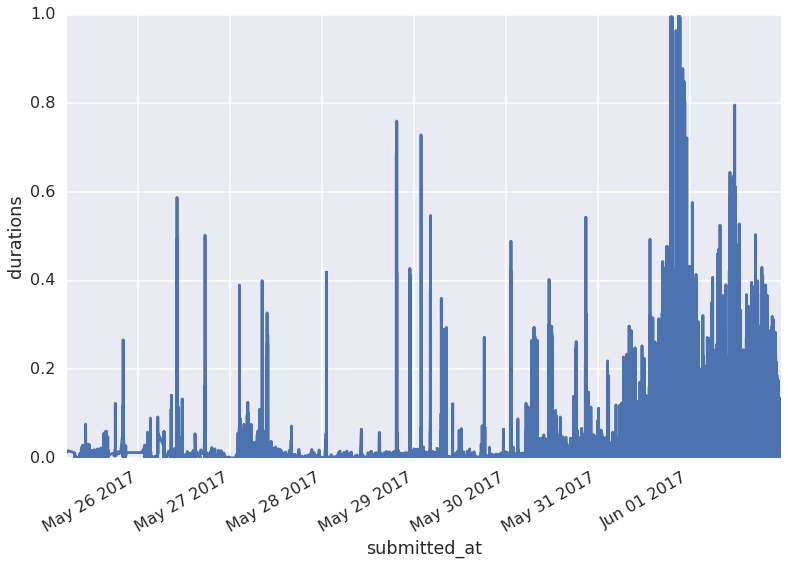

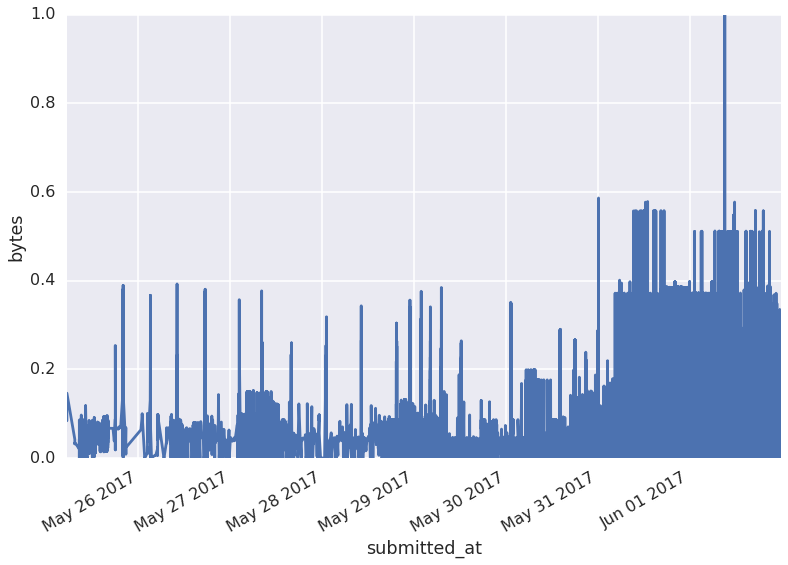

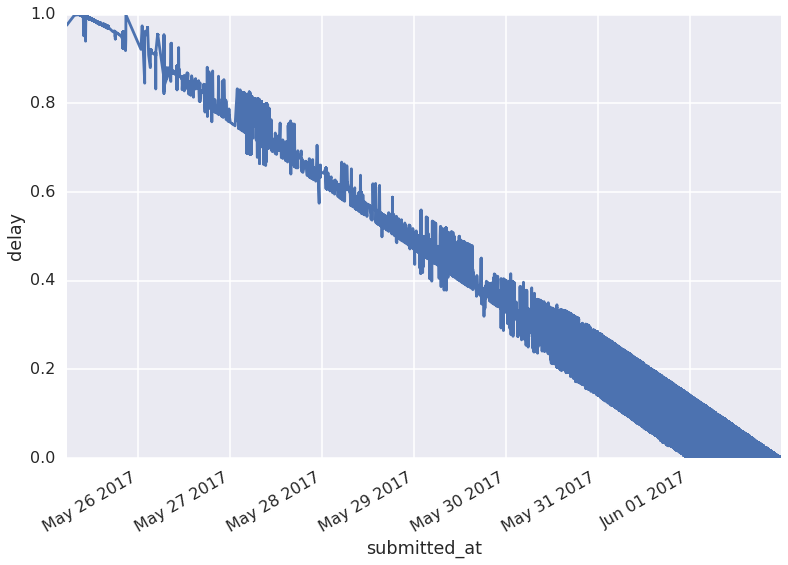

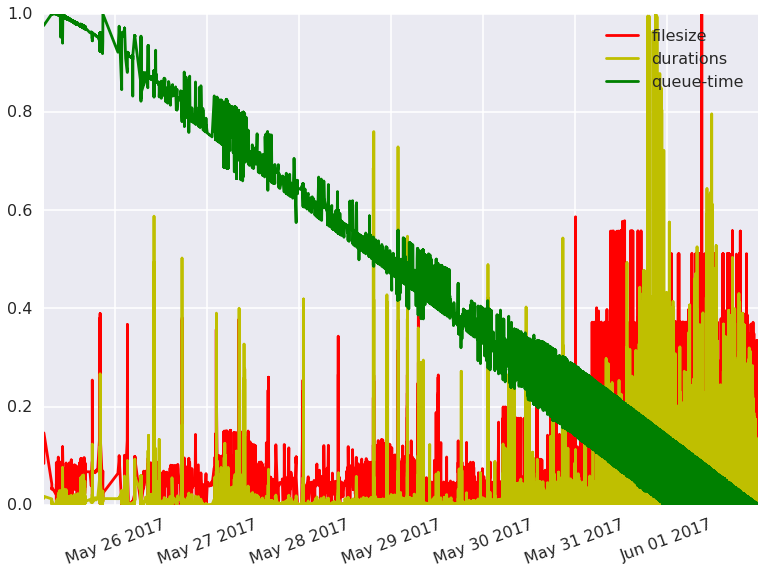

reading :  /eos/user/v/vysharma/atlas_rucio-events-2017.06.02.csv
shape : (1983351, 27)


/cvmfs/sft.cern.ch/lcg/views/LCG_88Py3/x86_64-slc6-gcc62-opt/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/cvmfs/sft.cern.ch/lcg/views/LCG_88Py3/x86_64-slc6-gcc62-opt/lib/python3.5/site-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/cvmfs/sft.cern.ch/lcg/views/LCG_88Py3/x86_64-slc6-gcc62-opt/lib/python3.5/site-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1,

using cached LabelEncoders for encoding data.....


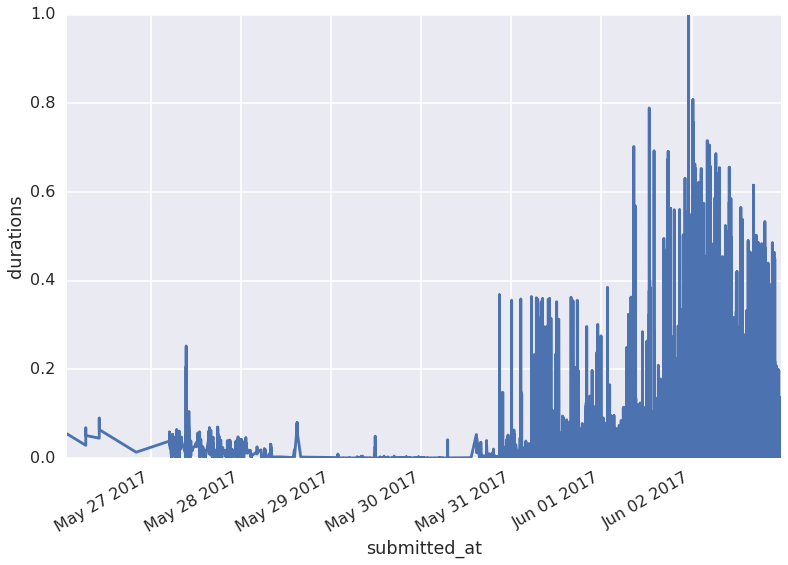

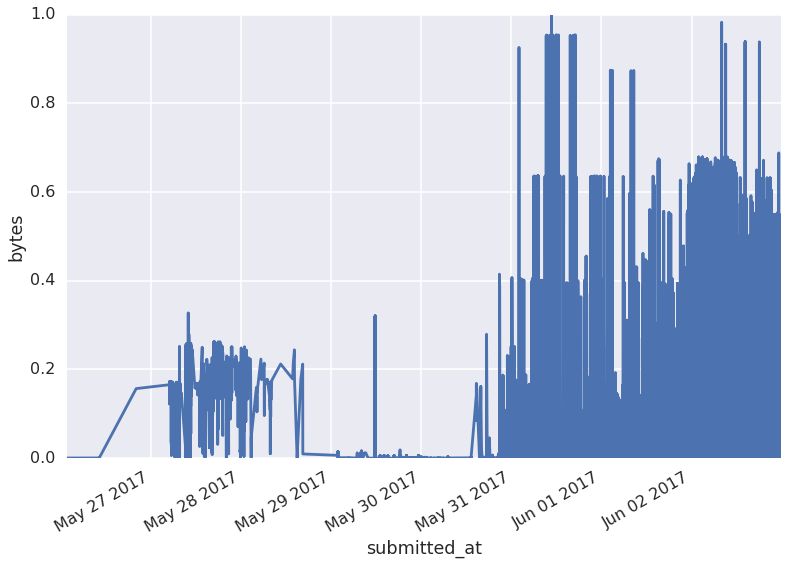

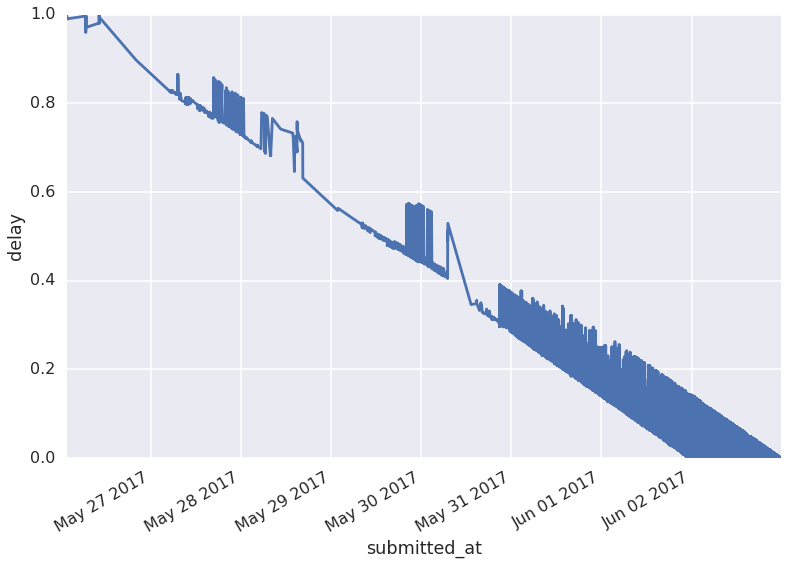

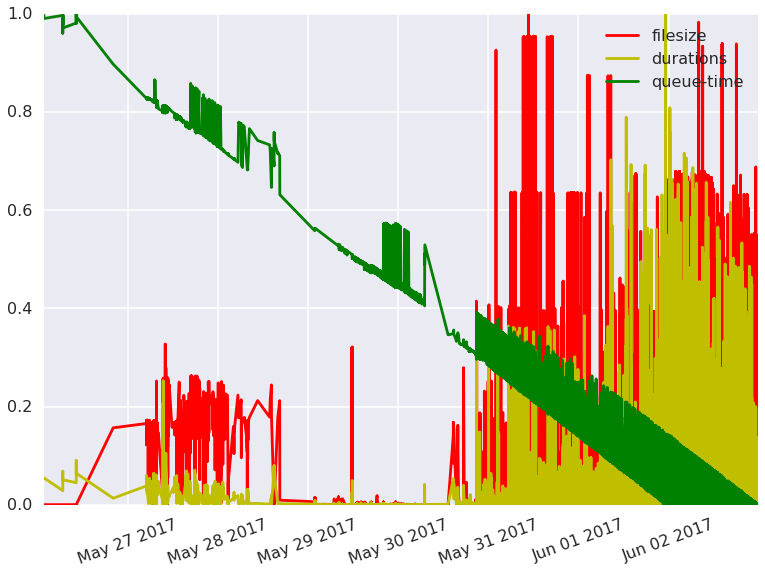

reading :  /eos/user/v/vysharma/atlas_rucio-events-2017.06.03.csv
shape : (1781815, 27)


/cvmfs/sft.cern.ch/lcg/views/LCG_88Py3/x86_64-slc6-gcc62-opt/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/cvmfs/sft.cern.ch/lcg/views/LCG_88Py3/x86_64-slc6-gcc62-opt/lib/python3.5/site-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/cvmfs/sft.cern.ch/lcg/views/LCG_88Py3/x86_64-slc6-gcc62-opt/lib/python3.5/site-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1,

using cached LabelEncoders for encoding data.....


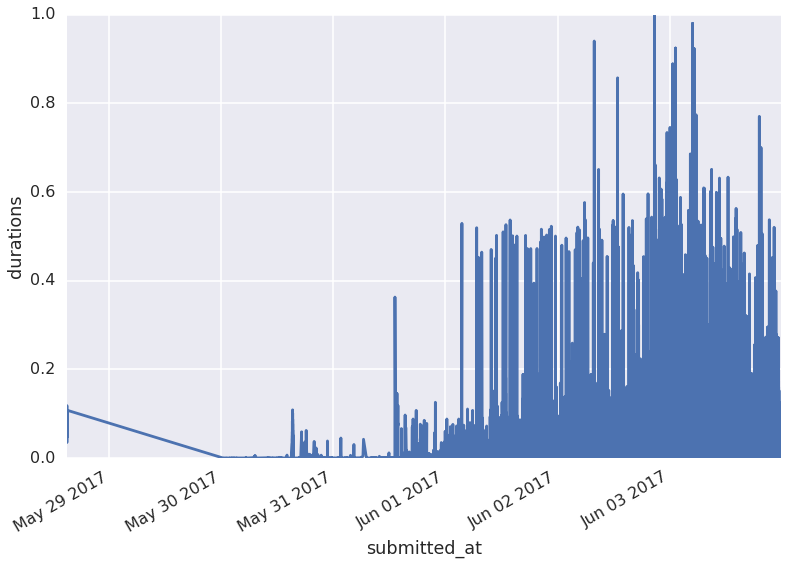

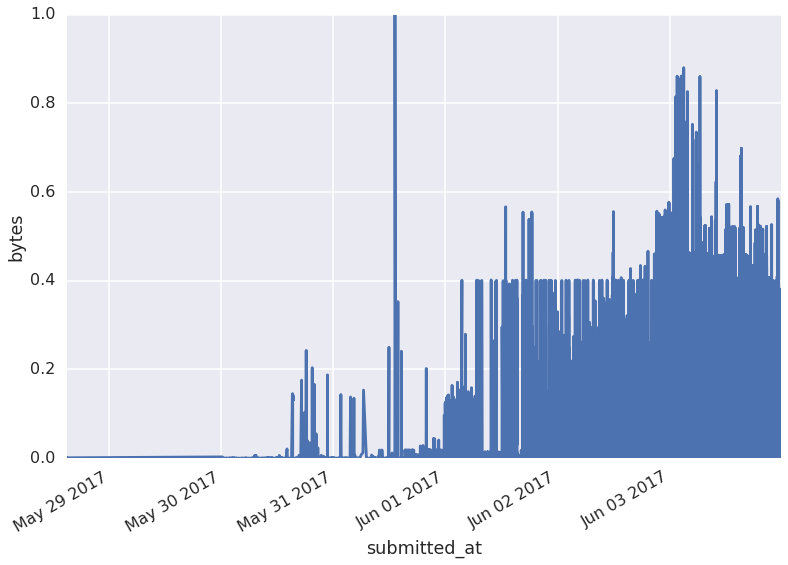

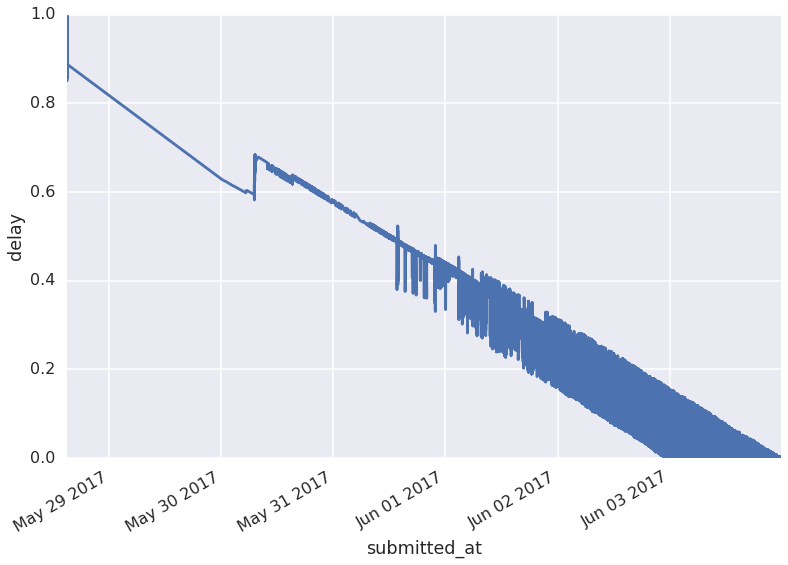

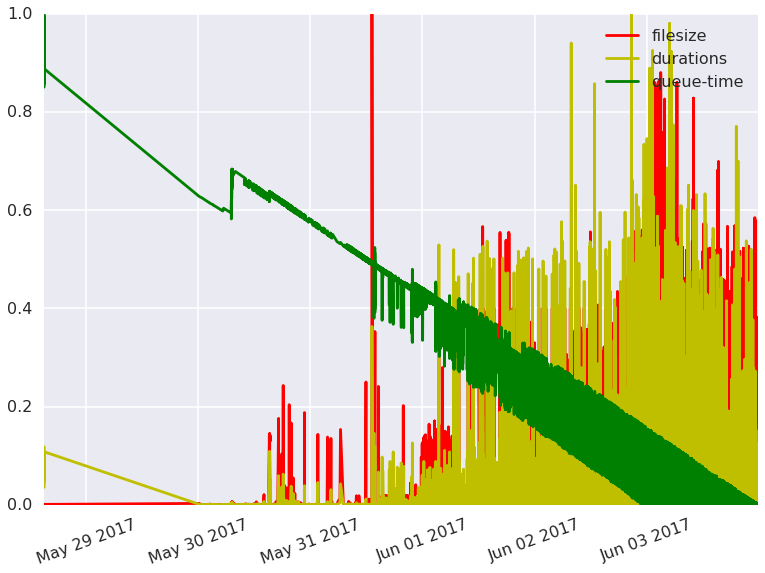

reading :  /eos/user/v/vysharma/atlas_rucio-events-2017.06.04.csv
shape : (1378899, 27)


/cvmfs/sft.cern.ch/lcg/views/LCG_88Py3/x86_64-slc6-gcc62-opt/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/cvmfs/sft.cern.ch/lcg/views/LCG_88Py3/x86_64-slc6-gcc62-opt/lib/python3.5/site-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/cvmfs/sft.cern.ch/lcg/views/LCG_88Py3/x86_64-slc6-gcc62-opt/lib/python3.5/site-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1,

using cached LabelEncoders for encoding data.....


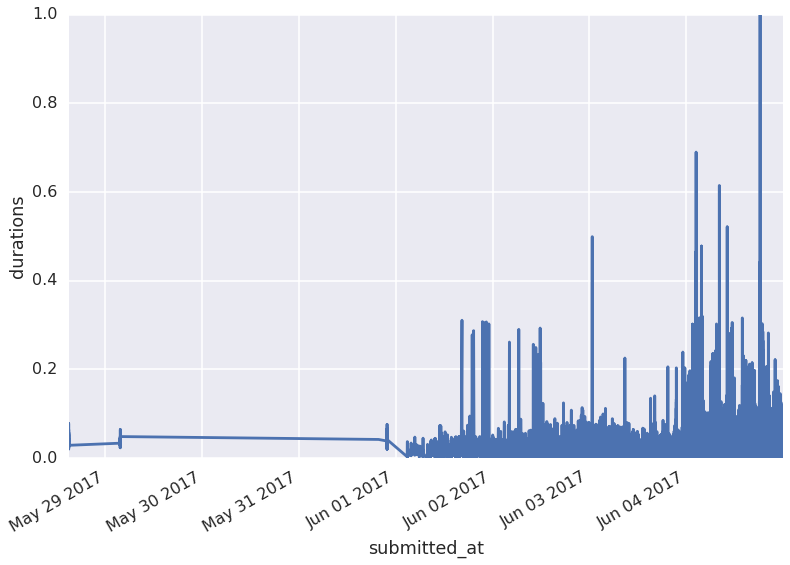

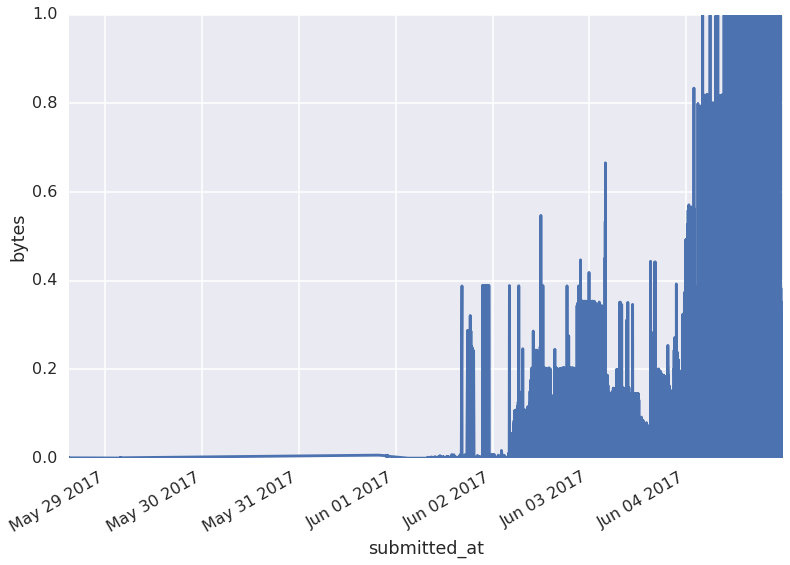

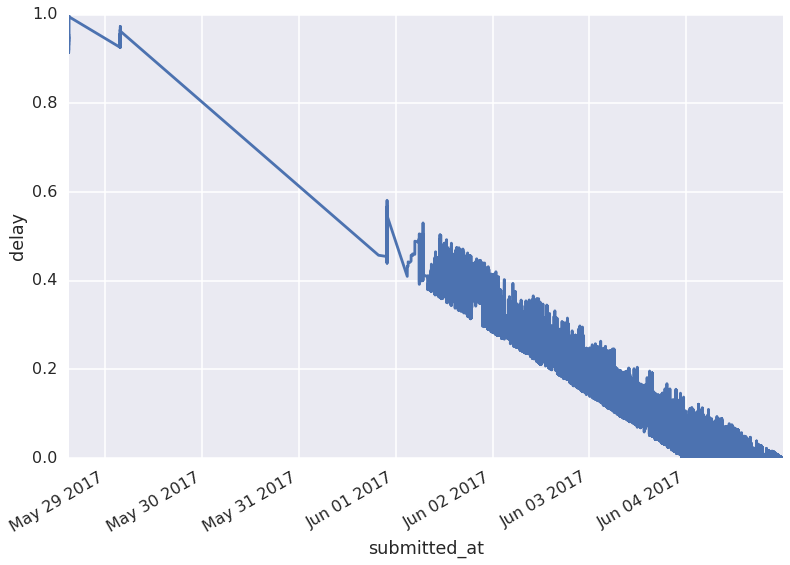

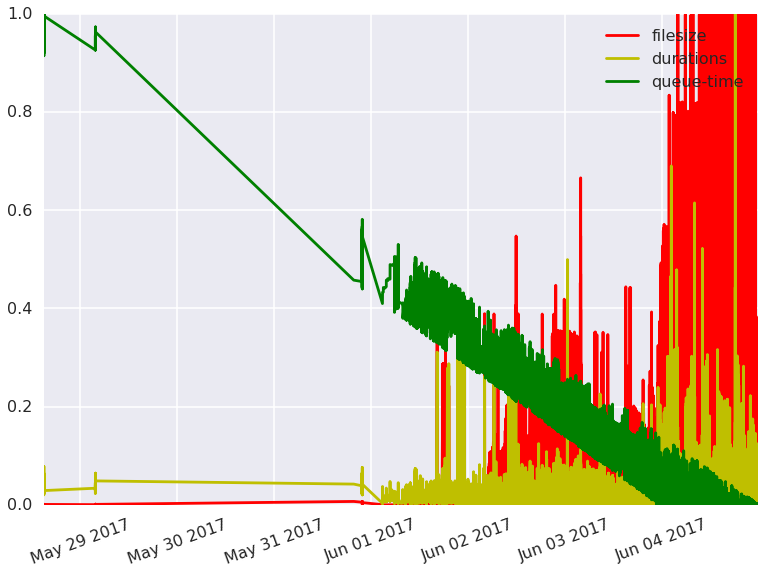

reading :  /eos/user/v/vysharma/atlas_rucio-events-2017.06.05.csv
shape : (2197839, 27)


/cvmfs/sft.cern.ch/lcg/views/LCG_88Py3/x86_64-slc6-gcc62-opt/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/cvmfs/sft.cern.ch/lcg/views/LCG_88Py3/x86_64-slc6-gcc62-opt/lib/python3.5/site-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/cvmfs/sft.cern.ch/lcg/views/LCG_88Py3/x86_64-slc6-gcc62-opt/lib/python3.5/site-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1,

using cached LabelEncoders for encoding data.....


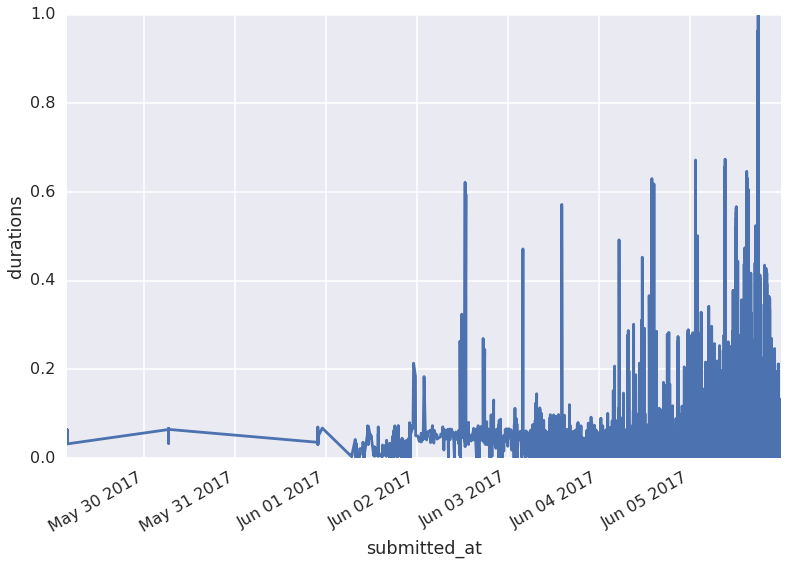

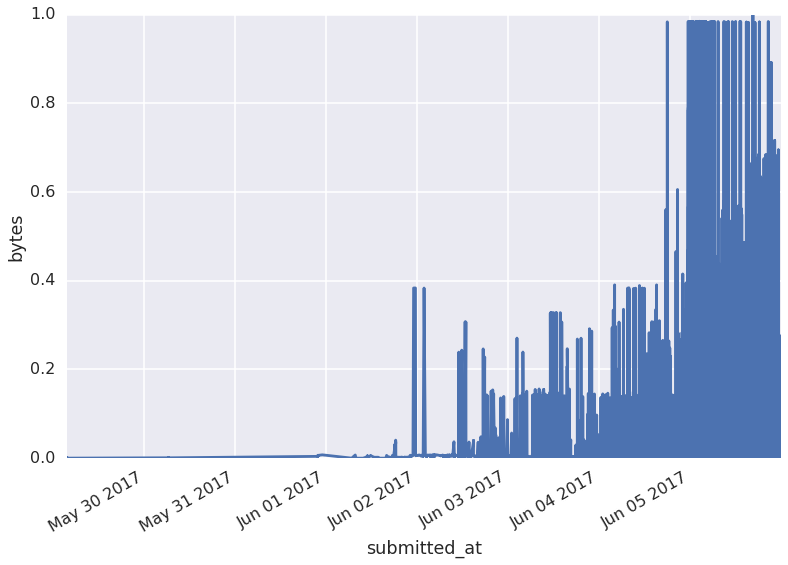

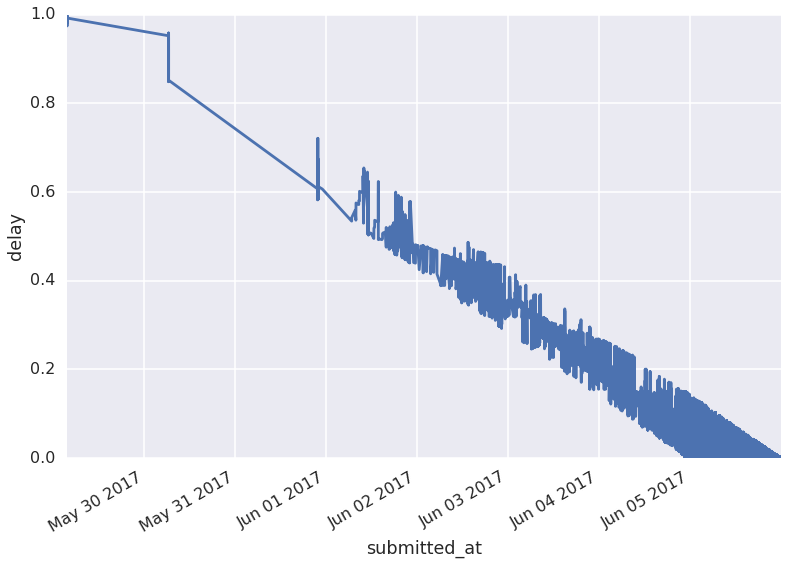

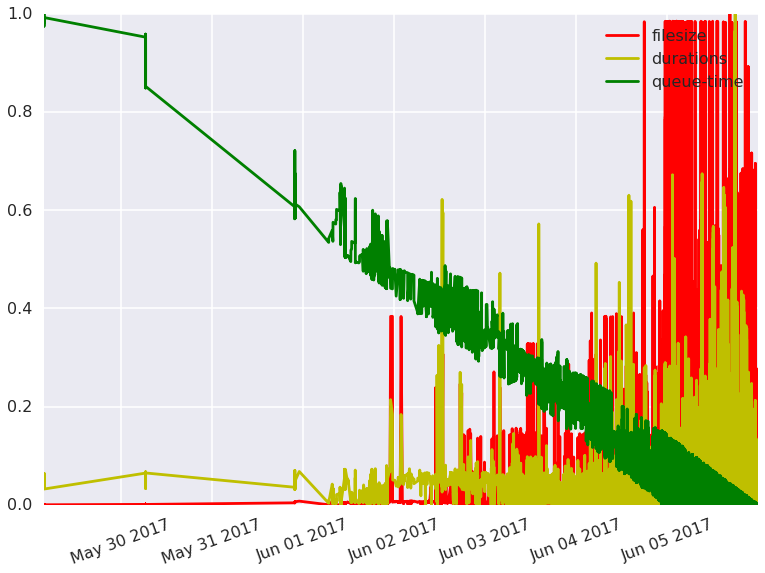

reading :  /eos/user/v/vysharma/atlas_rucio-events-2017.06.06.csv
shape : (2136482, 27)


/cvmfs/sft.cern.ch/lcg/views/LCG_88Py3/x86_64-slc6-gcc62-opt/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/cvmfs/sft.cern.ch/lcg/views/LCG_88Py3/x86_64-slc6-gcc62-opt/lib/python3.5/site-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/cvmfs/sft.cern.ch/lcg/views/LCG_88Py3/x86_64-slc6-gcc62-opt/lib/python3.5/site-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1,

using cached LabelEncoders for encoding data.....


ValueError: y contains new labels: ['default']

In [52]:
plot_rucio()

In [58]:
act_encoder = LabelEncoder()
act_encoder.classes_ = np.load('encoders/activity.npy')
print(act_encoder.classes_)
a = act_encoder.classes_
type(a)
a=np.append(a, 'default')
a


['Data Brokering' 'Data Consolidation' 'Data Rebalancing' 'Express'
 'Functional Test' 'Production Input' 'Production Output' 'Recovery'
 'Staging' 'T0 Export' 'T0 Tape' 'User Subscriptions']


array(['Data Brokering', 'Data Consolidation', 'Data Rebalancing',
       'Express', 'Functional Test', 'Production Input',
       'Production Output', 'Recovery', 'Staging', 'T0 Export', 'T0 Tape',
       'User Subscriptions', 'default'], dtype=object)